In [157]:
class Rect:
    def __init__(self, top, left, height, width):
        self.top = top
        self.left = left
        self.height = height
        self.width = width

        self.bottom = top + height
        self.right = left + width

    def __str__(self):
        return "TLBR=(" + str(self.top) + ", " + str(self.left) + ", " + str(self.bottom) + ", " + str(self.right) + ")" \
         + "    TLHW=(" + str(self.top) + ", " + str(self.left) + ", " + str(self.height) + ", " + str(self.width) + ")"

    def __repr__(self):
        return self.__str__()


In [126]:
def getDBAlbumXMLConfig(mcfxFile):
    import sqlite3

    con = sqlite3.connect(mcfxFile)
    cur = con.cursor()
    res = cur.execute("SELECT Data FROM Files WHERE Filename='data.mcf'")

    xmlData = res.fetchone()

    print('Successfully read XML data from', mcfxFile)
    cur.close()
    con.close()  
    
    # with open('data.mcf.xml', "wb") as f:
    #     f.write(xmlData[0])

    if isinstance(xmlData[0], str):
        xmlString = xmlData[0]
    else:
        xmlString = xmlData[0].decode('UTF8')

    xmlString = xmlString[:xmlString.find('</fotobook>')+11]

    return xmlString

In [120]:
def getPagesWithImages(tree):
    parentMap = {c: p for p in tree.iter() for c in p}

    images = {}
    imageToPositionElement = {}

    for areaElement in tree.iter('area'):
        if areaElement.get('areatype') == 'imagearea':
            parentElement = parentMap[areaElement]
            pageNumber = int(parentElement.get('pagenr'))

            # <position height="3160" left="-100" rotation="0" top="-100" width="6309.18" zposition="100"/>
            positionElement = areaElement.find('position')
            h = float(positionElement.get('height'))
            w = float(positionElement.get('width'))
            l = float(positionElement.get('left'))
            t = float(positionElement.get('top'))
            rect = Rect(t, l, h, w)

            if not pageNumber in images:
                images[pageNumber] = []

            images[pageNumber].append(rect)
            imageToPositionElement[rect] = positionElement

    return (images, imageToPositionElement)

In [163]:
def interfereHorizontally(i1, i2):
    if (i1.left >= i2.left and i1.left <= i2.right) or (i1.right >= i2.left and i1.right <= i2.right) or (i1.left < i2.left and i1.right > i2.right):
        return True
    return False

def interfereVertically(i1, i2):
    if (i1.top >= i2.top and i1.top <= i2.bottom) or (i1.bottom >= i2.top and i1.bottom <= i2.bottom) or (i1.top < i2.top and i1.bottom > i2.bottom):
        return True
    return False

def getBorderConstraints(i, pageHeight, pageWidth, margin):
    resultingConstraints = []
    
    resultingConstraints.append((i, 'T', margin))
    resultingConstraints.append((i, 'L', margin))
    resultingConstraints.append((i, 'H', pageHeight - margin))
    resultingConstraints.append((i, 'W', pageWidth - margin))

    return resultingConstraints

def getResultingConstraints(i1, i2, margin):
    resultingConstraints = []

    if i1.right <= i2.left:
        if interfereVertically(i1, i2):
            mid = i1.right + (i2.left - i1.right) / 2
            resultingConstraints.append((i1, 'W', i1.width + (mid - margin/2 - i1.right) ))
            resultingConstraints.append((i2, 'L', mid + margin/2))
    elif i1.left >= i2.right:
        if interfereVertically(i1, i2):
            mid = i2.right + (i1.left - i2.right) / 2
            resultingConstraints.append((i1, 'L', mid + margin/2))
            resultingConstraints.append((i2, 'W', i2.width + (mid - margin/2 - i2.right) ))

    if i1.bottom <= i2.top:
        if interfereHorizontally(i1, i2):
            mid = i1.bottom + (i2.top - i1.bottom) / 2
            resultingConstraints.append((i1, 'H', i1.height + (mid - margin/2 - i1.bottom) ))
            resultingConstraints.append((i2, 'T', mid + margin/2))
    elif i1.top >= i2.bottom:
        if interfereHorizontally(i1, i2):
            mid = i2.bottom + (i1.top - i2.bottom) / 2
            resultingConstraints.append((i1, 'T', mid + margin/2))
            resultingConstraints.append((i2, 'H', i2.height + (mid - margin/2 - i2.bottom) ))

    return resultingConstraints

In [164]:
# def getBorderRectangles(pageHeight, pageWidth):
#     return [Rect(0, -10, pageHeight, 10), # left border
#             Rect(-10, 0, 10, pageWidth), # top border
#             Rect(0, pageWidth, pageHeight, 10),  # right border
#             Rect(pageHeight, 0, 10, pageWidth)] # bottom border

def getNewCoordinates(pages, imageToPositionElement, pageHeight, pageWidth, newMargin):
    import itertools

    newCoordinates = {}

    for pageNumber in pages:
        images = pages[pageNumber]
        # borderRectangles = getBorderRectangles(pageHeight, pageWidth)
        # imageToPositionElement.update( {r : None for r in borderRectangles} )
        # images = images + borderRectangles

        allConstraints = []
        for i in images:
            allConstraints.extend(getBorderConstraints(i, pageHeight, pageWidth, newMargin))

        if pageNumber == 12:
            print()
    
        # for i1 in images:
        #     for i2 in images:
        for imagePair in itertools.combinations(images, 2):
            resultingConstraints = getResultingConstraints(imagePair[0], imagePair[1], newMargin)
            allConstraints = allConstraints + resultingConstraints

        newCoordinates[pageNumber] = {imageToPositionElement[i] : {'T':i.top, 'L':i.left, 'H':i.height, 'W':i.width} for i in images}

        for c in allConstraints:
            positionElement = imageToPositionElement[c[0]]

            if not positionElement is None:
                oldVal = newCoordinates[pageNumber][positionElement][c[1]]

                if c[1]=='T' or c[1]=='L':
                    if c[2] > oldVal:
                        newCoordinates[pageNumber][positionElement][c[1]] = c[2]
                else:
                    if c[2] < oldVal:
                        newCoordinates[pageNumber][positionElement][c[1]] = c[2]
    
    return newCoordinates

In [123]:
def adjustCoordinates(tree, newCoordinates):
    for pageNumber in newCoordinates:
        for (posEl, constraints) in newCoordinates[pageNumber].items():
            if not posEl is None:
                posEl.set('top', str(constraints['T']))
                posEl.set('left', str(constraints['L']))
                posEl.set('height', str(constraints['H']))
                posEl.set('width', str(constraints['W']))
            
    return None

In [167]:
import xml.etree.ElementTree as et

xmlString = getDBAlbumXMLConfig('test.mcfx')
root = et.fromstring(xmlString)

(pages, imageToPositionElement) = getPagesWithImages(root)

pageHeight = 2900 #2960
pageWidth = 5800 #6010
newMargin = 200

newCoordinates = getNewCoordinates(pages, imageToPositionElement, pageHeight, pageWidth, newMargin)

adjustCoordinates(root, newCoordinates)
newXML = et.tostring(root)

et.ElementTree(root).write(open('data.mcf.new.xml', 'wb'), encoding='UTF-8', xml_declaration=True)


Successfully read XML data from test.mcfx


KeyError: (TLBR=(-100.0, -100.0, 3060.0, 6209.18)    TLHW=(-100.0, -100.0, 3160.0, 6309.18), 'T', 200)

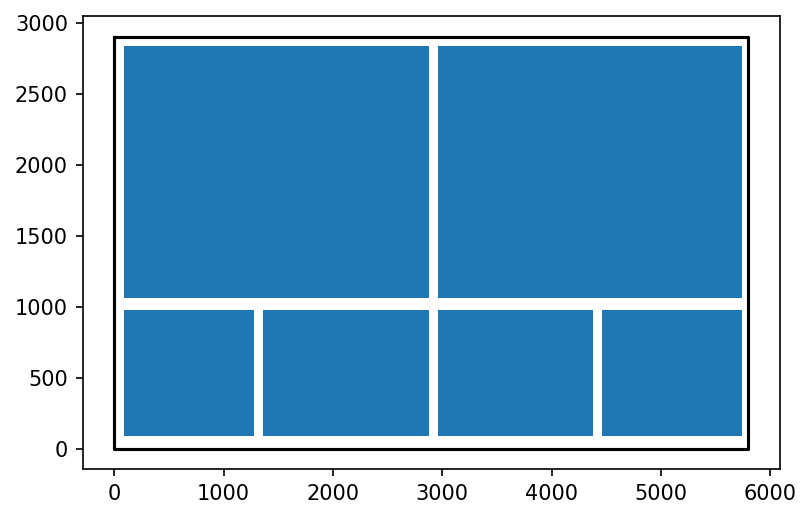

In [152]:
(pages, imageToPositionElement) = getPagesWithImages(root)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rcParams['figure.dpi'] = 150

fig, ax = plt.subplots()
ax.plot([0, 0, pageWidth, pageWidth, 0],[pageHeight, 0, 0, pageHeight, pageHeight], 'k')

for i in pages[12]:
    ax.add_patch(Rectangle((i.left, i.top), i.width, i.height))

plt.show()